In [8]:
import tensorflow_datasets as tfds
import tensorflow as tf
import logging, os
import pandas as pd
import time
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"cats_vs_dogs_transfer/"
os.system("mkdir -p " + OUTPUT_PATH)


(train_dataset, validation_dataset),metadata = tfds.load(
    "cats_vs_dogs",
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    with_info=True,
    as_supervised=True,  # Include labels
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_test = tf.data.experimental.cardinality(validation_dataset)

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")

size = (150, 150)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
validation_dataset = validation_dataset.map(lambda x, y: \
                                  (tf.image.resize(x, size), y))

batch_size = 32

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache() \
    .batch(batch_size).prefetch(buffer_size=10)

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Number of training samples: 9305
Number of validation samples: 2326


In [9]:
# Load model
filename = "valacc_0.972_epochs_4_date_20250726-214355.h5"

fullpath = f"{OUTPUT_PATH}{filename}"
model = load_model(fullpath)
model.summary()


# Make predictions
predictions = model.predict(validation_dataset)
allpreds=predictions.flatten()
allpnorms = np.where(allpreds > 0.5, 1, 0)

alllabels=np.empty(0)
for images, labels in validation_dataset:
    alllabels = np.append(alllabels, labels.numpy().flatten())

score = metrics.accuracy_score(alllabels, allpnorms)
print("Validation accuracy score: {}".format(score))

collabels = pd.DataFrame(alllabels, columns=["l"])
colpreds = pd.DataFrame( allpreds, columns=["pred"])
pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
diff = collabels["l"] - pnorm["pnorm"]

compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
compare.columns = ["l", "pred", "pnorm","diff"]
print(compare)

compare.to_csv(OUTPUT_PATH + "pred_test_load.csv", index=False)    

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                           

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


73/73 [==============================] - 1s 13ms/step
Validation accuracy score: 0.9720550300945829
        l      pred  pnorm  diff
0     0.0 -8.700836      0   0.0
1     1.0  4.693343      1   0.0
2     0.0 -9.341220      0   0.0
3     0.0 -2.910272      0   0.0
4     1.0  0.659717      1   0.0
...   ...       ...    ...   ...
2321  0.0 -7.481091      0   0.0
2322  0.0 -6.783258      0   0.0
2323  1.0  4.570061      1   0.0
2324  1.0  6.784830      1   0.0
2325  0.0 -6.564024      0   0.0

[2326 rows x 4 columns]


,image,label,predictions,pred norm,correct
0,,0 (cat),-8.700836,0,True
1,,1 (dog),4.693343,1,True
2,,0 (cat),-9.341220,0,True
3,,0 (cat),-2.910272,0,True
4,,1 (dog),0.659717,1,True
5,,0 (cat),-7.766264,0,True
6,,0 (cat),-2.306379,0,True
7,,1 (dog),6.998990,1,True
8,,1 (dog),7.761320,1,True
9,,0 (cat),1.110353,1,False

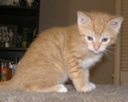
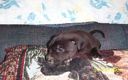
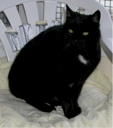
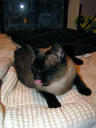
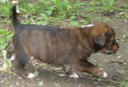
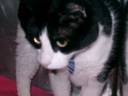
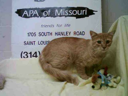
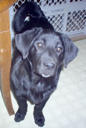
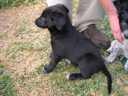
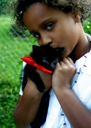
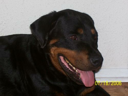
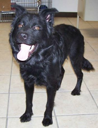
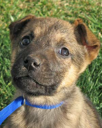
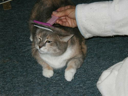
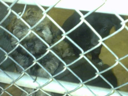
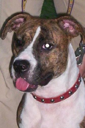
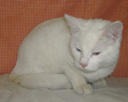
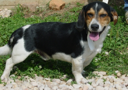
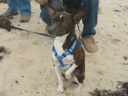
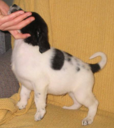
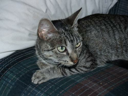
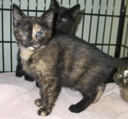
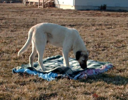
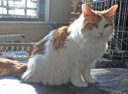
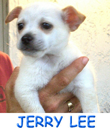
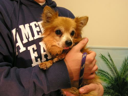
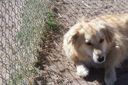
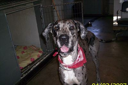
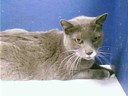
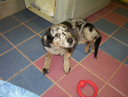
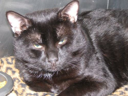
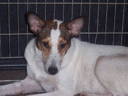
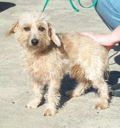
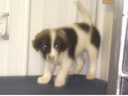
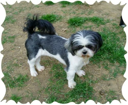
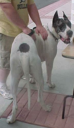
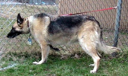
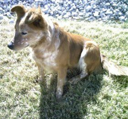
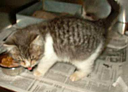
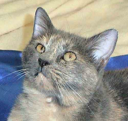
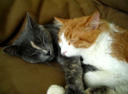
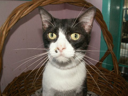
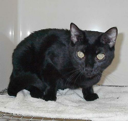
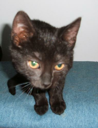
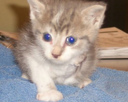
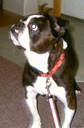
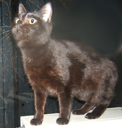
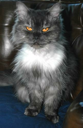
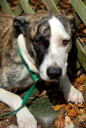
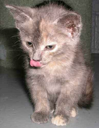
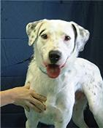
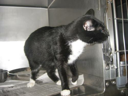
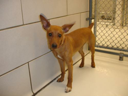
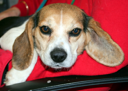
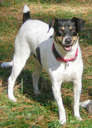
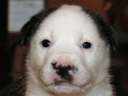
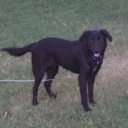
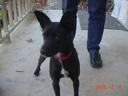
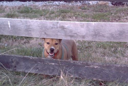
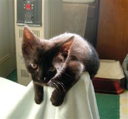
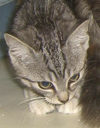
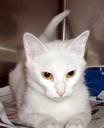
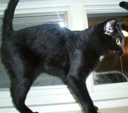
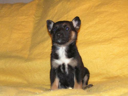
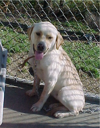
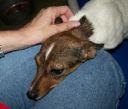
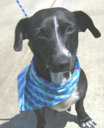
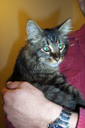
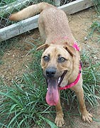
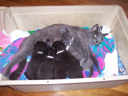
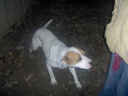
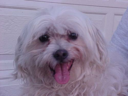
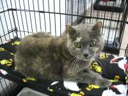
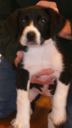
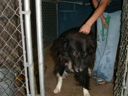
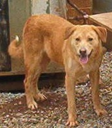
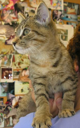
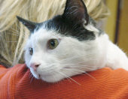
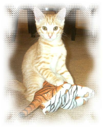
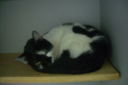
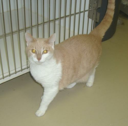
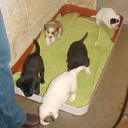
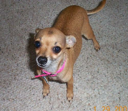
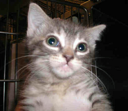
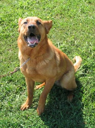
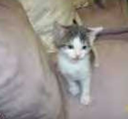
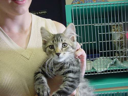
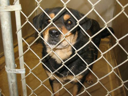
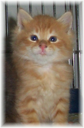
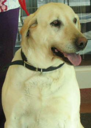
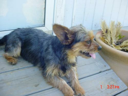
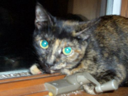
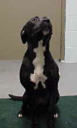
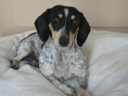
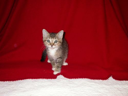
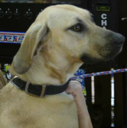
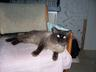
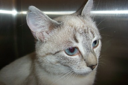
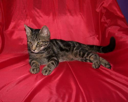
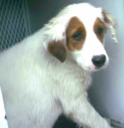

In [12]:
# Reload the dataset (need without pre-processing)
(train_dataset, validation_dataset),metadata = tfds.load(
    "cats_vs_dogs",
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    with_info=True,
    as_supervised=True,  # Include labels
)

number_of_images=100
allcorrect = (allpnorms == alllabels)

new_df=tfds.as_dataframe(validation_dataset.take(number_of_images), metadata)
# new_df
new_df['predictions'] = allpreds[0:number_of_images]
new_df['pred norm'] = allpnorms[0:number_of_images]
new_df['correct'] = allcorrect[0:number_of_images]
new_df